# Medical Appointments No-shows 
### Why do 20% of patients miss their scheduled appointments?

#### A person makes a doctor appointment, receives all the instructions and doesn't show up. 
#### Is it feasible to predict this behaviour?  

The data contains 110,527 medical appointments with 14 features: 
- Patient ID 
- Appointment ID 
- Gender- Patient Gender 
- ScheduledDay- day appointment was scheduled 
- AppointmentDay- day of appointment 
- Age- Patient age 
- Neighbourhood- appointment location 
- Scholarship- is the patient part of the 'Bolsa Família' welfair plan (https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia)
- Hypertension- does the patient suffer from Hypertension (1/ 0) 
- Diabetes- does the patient suffer from Diabetes (1/ 0)
- Alcoholism- does the patient suffer from Alcoholism (1/ 0)
- Handicap- is the patient a Handicap (1/ 0) 
- SMS_received- did the patient receive at least one sms message (1/ 0)
- No-show- did the patient keep their appointment (1/ 0)

## 1. Data Pre-processing

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.compose import make_column_transformer 
from sklearn.preprocessing import MinMaxScaler 
import category_encoders as ce
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV, cross_val_score, cross_validate 
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier  
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import make_pipeline 
from sklearn.metrics import classification_report 
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn import set_config
set_config(display='diagram')

In [2]:
df= pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


- no missing values

In [4]:
df= df.rename({'Hipertension': 'Hypertension', 'Handcap': 'Handicap', 'No-show': 'No_show'}, axis=1)

In [5]:
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received', 'No_show'],
      dtype='object')

In [6]:
for i in df.columns:
    print(i+":",df[i].nunique())

PatientId: 62299
AppointmentID: 110527
Gender: 2
ScheduledDay: 103549
AppointmentDay: 27
Age: 104
Neighbourhood: 81
Scholarship: 2
Hypertension: 2
Diabetes: 2
Alcoholism: 2
Handicap: 5
SMS_received: 2
No_show: 2


- as can be seen, some patients made multiple appointments.

In [7]:
df.No_show= df.No_show.map({'No': 0, 'Yes': 1})
df.Gender= df.Gender.map({'F': 0, 'M': 1})
df['PatientId']= df['PatientId'].astype('int64')

In [8]:
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay']).dt.date.astype('datetime64[ns]')
df['AppointmentDay']= pd.to_datetime(df['AppointmentDay']).dt.date.astype('datetime64[ns]')

In [9]:
df.head(2)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show
0,29872499824296,5642903,0,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,0
1,558997776694438,5642503,1,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,0


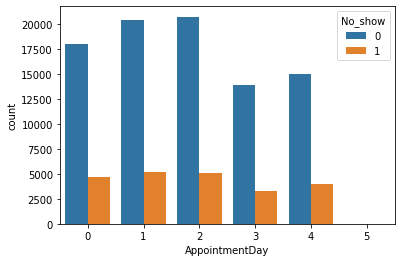

In [10]:
sns.countplot(data=df, x=df.AppointmentDay.dt.day_of_week, hue= 'No_show');

- near zero variance in day_of_week, this feature will therefor not be added. 

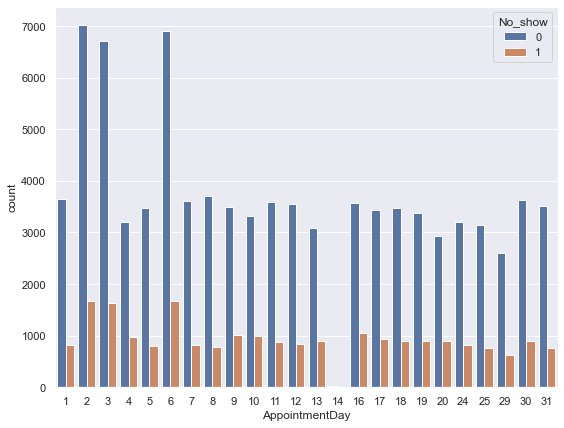

In [11]:
sns.set(rc = {'figure.figsize':(9,7)})
sns.countplot(data=df, x=df.AppointmentDay.dt.day, hue= 'No_show');

- adding 2 more features: AppointmentDay_of_month and days_to_app(=days to appointment):

In [12]:
df['AppointmentDay_of_month']= df.AppointmentDay.dt.day
df['days_to_app']= (df['AppointmentDay']- df['ScheduledDay']).dt.days 
df.days_to_app.unique()

array([  0,   2,   3,   1,   4,   9,  29,  10,  23,  11,  18,  17,  14,
        28,  24,  21,  15,  16,  22,  43,  30,  31,  42,  32,  56,  45,
        46,  39,  37,  38,  44,  50,  60,  52,  53,  65,  67,  91,  66,
        84,  78,  87, 115, 109,  63,  70,  72,  57,  58,  51,  59,  41,
        49,  73,  64,  20,  33,  34,   6,  35,  36,  12,  13,  40,  47,
         8,   5,   7,  25,  26,  48,  27,  19,  61,  55,  62, 176,  54,
        77,  69,  83,  76,  89,  81, 103,  79,  68,  75,  85, 112,  -1,
        80,  86,  98,  94, 142, 155, 162, 169, 104, 133, 125,  96,  88,
        90, 151, 126, 127, 111, 119,  74,  71,  82, 108, 110, 102, 122,
       101, 105,  92,  97,  93, 107,  95,  -6, 139, 132, 179, 117, 146,
       123], dtype=int64)

- filtering out negative days values: 

In [13]:
df= df[df['days_to_app']>=0]

In [14]:
df.days_to_app.unique()

array([  0,   2,   3,   1,   4,   9,  29,  10,  23,  11,  18,  17,  14,
        28,  24,  21,  15,  16,  22,  43,  30,  31,  42,  32,  56,  45,
        46,  39,  37,  38,  44,  50,  60,  52,  53,  65,  67,  91,  66,
        84,  78,  87, 115, 109,  63,  70,  72,  57,  58,  51,  59,  41,
        49,  73,  64,  20,  33,  34,   6,  35,  36,  12,  13,  40,  47,
         8,   5,   7,  25,  26,  48,  27,  19,  61,  55,  62, 176,  54,
        77,  69,  83,  76,  89,  81, 103,  79,  68,  75,  85, 112,  80,
        86,  98,  94, 142, 155, 162, 169, 104, 133, 125,  96,  88,  90,
       151, 126, 127, 111, 119,  74,  71,  82, 108, 110, 102, 122, 101,
       105,  92,  97,  93, 107,  95, 139, 132, 179, 117, 146, 123],
      dtype=int64)

- checking for classes imbalance:  

In [15]:
df.No_show.value_counts(normalize=True).round(2)

0    0.8
1    0.2
Name: No_show, dtype: float64

- clearly there is a class imbalance in the data of 4:1 for show: No_show, respectively. 

## 2. EDA

In [16]:
df= df[df.Age>=0]
df[df.Age==0]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show,AppointmentDay_of_month,days_to_app
59,71844284745331,5638545,0,2016-04-29,2016-04-29,0,CONQUISTA,0,0,0,0,0,0,0,29,0
63,236623344873175,5628286,1,2016-04-27,2016-04-29,0,SÃO BENEDITO,0,0,0,0,0,0,0,29,2
64,188517384712787,5616082,1,2016-04-25,2016-04-29,0,ILHA DAS CAIEIRAS,0,0,0,0,0,1,0,29,4
65,271881817799985,5628321,1,2016-04-27,2016-04-29,0,CONQUISTA,0,0,0,0,0,0,0,29,2
67,86471282513499,5639264,0,2016-04-29,2016-04-29,0,NOVA PALESTINA,0,0,0,0,0,0,0,29,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110345,147395196662956,5702537,0,2016-05-16,2016-06-01,0,RESISTÊNCIA,0,0,0,0,0,0,0,1,16
110346,5577525313231,5777724,1,2016-06-06,2016-06-08,0,RESISTÊNCIA,0,0,0,0,0,0,0,8,2
110454,614245995575,5772400,0,2016-06-03,2016-06-03,0,RESISTÊNCIA,0,0,0,0,0,0,0,3,0
110460,43218463343323,5769545,0,2016-06-03,2016-06-03,0,RESISTÊNCIA,0,0,0,0,0,0,0,3,0


- Age value of 0 most likely represents babies under 1 years of age, therefor not an error.

- cleanng the data of Age outliers:

In [17]:
q75, q25 = np.percentile(df.Age, [75 ,25])

In [18]:
iqr= q75-q25
upper_lim= q75+iqr*1.5
lower_lim= q25-iqr*1.5
print('upper lim:', upper_lim)
print('lower lim:', lower_lim)

upper lim: 110.5
lower lim: -37.5


In [19]:
df[df.Age>upper_lim]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show,AppointmentDay_of_month,days_to_app
63912,31963211613981,5700278,0,2016-05-16,2016-05-19,115,ANDORINHAS,0,0,0,0,1,0,1,19,3
63915,31963211613981,5700279,0,2016-05-16,2016-05-19,115,ANDORINHAS,0,0,0,0,1,0,1,19,3
68127,31963211613981,5562812,0,2016-04-08,2016-05-16,115,ANDORINHAS,0,0,0,0,1,0,1,16,38
76284,31963211613981,5744037,0,2016-05-30,2016-05-30,115,ANDORINHAS,0,0,0,0,1,0,0,30,0
97666,748234579244724,5717451,0,2016-05-19,2016-06-03,115,SÃO JOSÉ,0,1,0,0,0,1,0,3,15


In [20]:
df= df.drop(df[df['Age']>upper_lim].index)

In [21]:
df= df.drop(['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay'], axis=1)

In [22]:
df.head(2)

,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show,AppointmentDay_of_month,days_to_app
0,0,62,JARDIM DA PENHA,0,1,0,0,0,0,0,29,0
1,1,56,JARDIM DA PENHA,0,0,0,0,0,0,0,29,0


- checking the distribution of no-show rates of the different Neighbourhoods:

In [23]:
neighbourhood= df[['Neighbourhood', 'No_show']].pivot_table(index='Neighbourhood', fill_value='No_show', aggfunc=['count', 'sum']).reset_index()
neighbourhood.columns= ['Neighbourhood', 'Appointments', 'No_shows']
neighbourhood['No_show_rate']= (neighbourhood.No_shows/ neighbourhood.Appointments).round(2)
neighbourhood= neighbourhood.sort_values(by='No_show_rate', ascending=False)
neighbourhood

,Neighbourhood,Appointments,No_shows,No_show_rate
34,ILHAS OCEÂNICAS DE TRINDADE,2,2,1.00
70,SANTOS DUMONT,1276,369,0.29
61,SANTA CECÍLIA,448,123,0.27
36,ITARARÉ,3514,923,0.26
62,SANTA CLARA,506,134,0.26
...,...,...,...,...
73,SOLON BORGES,469,69,0.15
16,DE LOURDES,305,47,0.15
0,AEROPORTO,8,1,0.12
31,ILHA DO BOI,35,3,0.09


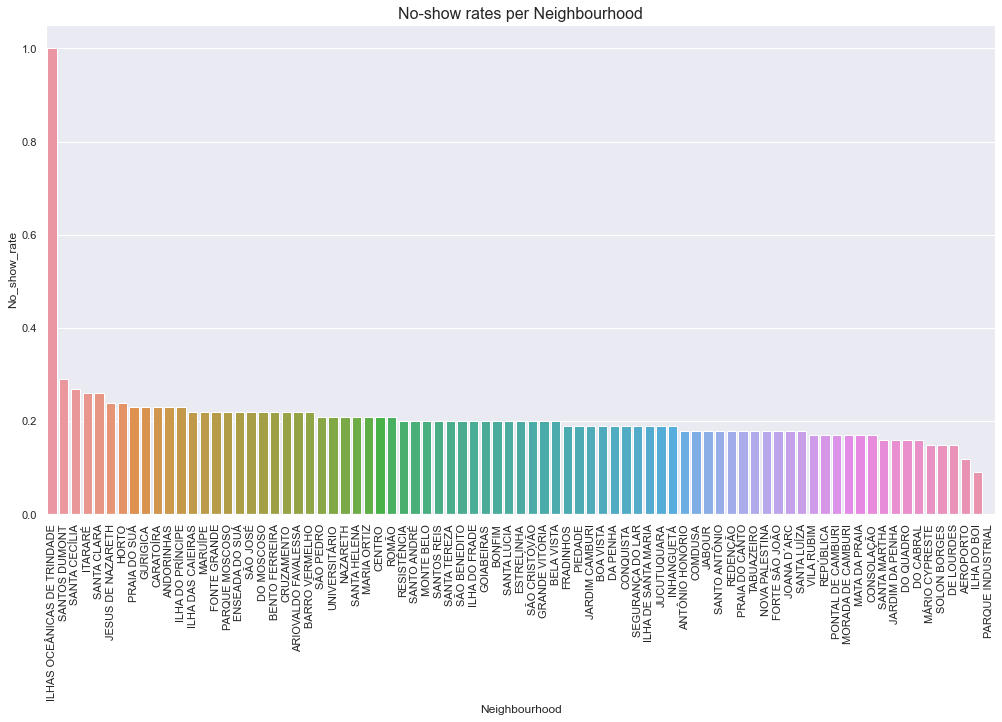

In [24]:
sns.set(rc = {'figure.figsize':(17,9)})
sns.barplot(data=neighbourhood, x='Neighbourhood', y='No_show_rate').set_title('No-show rates per Neighbourhood', fontsize=16)
plt.xticks(rotation=90);

- dropping No_show_rate outlier neighbourhoods from dataset:

In [25]:
q75, q25 = np.percentile(neighbourhood.No_show_rate, [75 ,25])
iqr= q75-q25
upper_lim= q75+iqr*1.5
lower_lim= q25-iqr*1.5
print('upper lim:', upper_lim.round(2))
print('lower lim:', lower_lim.round(2))

upper lim: 0.28
lower lim: 0.12


Neighbourhoods exhibiting outlying rates of No-shows:

In [26]:
neighbourhoods_to_drop= neighbourhood[(neighbourhood.No_show_rate<lower_lim)|(neighbourhood.No_show_rate>upper_lim)]['Neighbourhood'].tolist()
neighbourhoods_to_drop

['ILHAS OCEÂNICAS DE TRINDADE',
 'SANTOS DUMONT',
 'ILHA DO BOI',
 'PARQUE INDUSTRIAL']

In [27]:
df= df.drop(df[df.Neighbourhood.isin(neighbourhoods_to_drop)].index)
df.shape

(109202, 12)

## 3. Modeling and Predictions

In [28]:
X= df.drop('No_show', axis=1)
y= df['No_show']

In [29]:
print(X.shape, y.shape)

(109202, 11) (109202,)


In [30]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(76441, 11) (32761, 11) (76441,) (32761,)


In [32]:
numerical_features= X.select_dtypes(include='number').columns.to_list()
numerical_features

['Gender',
 'Age',
 'Scholarship',
 'Hypertension',
 'Diabetes',
 'Alcoholism',
 'Handicap',
 'SMS_received',
 'AppointmentDay_of_month',
 'days_to_app']

In [33]:
categorical_features= X.select_dtypes(exclude='number').columns.to_list()
categorical_features

['Neighbourhood']

In [34]:
preprocessor= make_column_transformer((MinMaxScaler(), numerical_features), (ce.BinaryEncoder(), categorical_features))
smote= SMOTE(random_state=42)

#### Dummy Classifier

In [35]:
dummy= DummyClassifier(random_state=42, strategy='stratified')
dummy_pipe= make_pipeline(preprocessor, dummy)

In [36]:
dummy_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['Gender', 'Age',
                                                   'Scholarship',
                                                   'Hypertension', 'Diabetes',
                                                   'Alcoholism', 'Handicap',
                                                   'SMS_received',
                                                   'AppointmentDay_of_month',
                                                   'days_to_app']),
                                                 ('binaryencoder',
                                                  BinaryEncoder(),
                                                  ['Neighbourhood'])])),
                ('dummyclassifier',
                 DummyClassifier(random_state=42, strategy='stratified'))])

In [37]:
dummy_pred= dummy_pipe.predict(X_test)
print(classification_report(y_test, dummy_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80     26183
           1       0.20      0.20      0.20      6578

    accuracy                           0.68     32761
   macro avg       0.50      0.50      0.50     32761
weighted avg       0.68      0.68      0.68     32761



#### RandomForest Classifier

In [38]:
rndForest= RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators= 200, max_depth=8)
rndForest_pipe= make_pipeline(preprocessor, smote, rndForest)

In [39]:
randomForest= cross_val_score(rndForest_pipe, X_train, y_train, scoring='f1')

In [40]:
print('Best roc_auc score for RandomForest classifier:', randomForest.mean().round(2))

Best roc_auc score for RandomForest classifier: 0.44


In [41]:
rndForest_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['Gender', 'Age',
                                                   'Scholarship',
                                                   'Hypertension', 'Diabetes',
                                                   'Alcoholism', 'Handicap',
                                                   'SMS_received',
                                                   'AppointmentDay_of_month',
                                                   'days_to_app']),
                                                 ('binaryencoder',
                                                  BinaryEncoder(),
                                                  ['Neighbourhood'])])),
                ('smote', SMOTE(random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=8,
                                        n_estimators=200, random_state=42))])

In [42]:
randomForest_pred= rndForest_pipe.predict(X_test)
print(classification_report(y_test, randomForest_pred))

              precision    recall  f1-score   support

           0       0.91      0.55      0.69     26183
           1       0.30      0.78      0.44      6578

    accuracy                           0.60     32761
   macro avg       0.61      0.66      0.56     32761
weighted avg       0.79      0.60      0.64     32761



#### GradientBoosting classifier

In [43]:
grb= GradientBoostingClassifier(random_state=42)
grb_pipe= make_pipeline(preprocessor, smote, grb)

In [44]:
grb_params= dict(gradientboostingclassifier__criterion=['friedman_mse', 'squared_error'], gradientboostingclassifier__learning_rate=[0.05, 0.1, 0.5], gradientboostingclassifier__n_estimators=[300, 400], gradientboostingclassifier__random_state=[42])

In [45]:
grb_result= cross_val_score(grb_pipe, X_train, y_train, cv=5, scoring='f1' )

In [46]:
print('Best f1 score for GradientBoosting classifier:', grb_result.mean().round(2))  

Best f1 score for GradientBoosting classifier: 0.42


In [47]:
grb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['Gender', 'Age',
                                                   'Scholarship',
                                                   'Hypertension', 'Diabetes',
                                                   'Alcoholism', 'Handicap',
                                                   'SMS_received',
                                                   'AppointmentDay_of_month',
                                                   'days_to_app']),
                                                 ('binaryencoder',
                                                  BinaryEncoder(),
                                                  ['Neighbourhood'])])),
                ('smote', SMOTE(random_state=42)),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=42))])

In [48]:
grb_pred= grb_pipe.predict(X_test)
print(classification_report(y_test, grb_pred))

              precision    recall  f1-score   support

           0       0.87      0.72      0.78     26183
           1       0.33      0.56      0.42      6578

    accuracy                           0.69     32761
   macro avg       0.60      0.64      0.60     32761
weighted avg       0.76      0.69      0.71     32761



#### HistGradientBoosting classifier

In [49]:
hgrb= HistGradientBoostingClassifier(random_state=42)
hgrb_pipe= make_pipeline(preprocessor, smote, hgrb)

In [50]:
hgrb_result= cross_val_score(hgrb_pipe, X_train, y_train, scoring='f1', cv=5)

In [51]:
print('Mean f1 score for HistGradientBoosting classifier:', hgrb_result.mean().round(2))  

Mean f1 score for HistGradientBoosting classifier: 0.34


In [52]:
hgrb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['Gender', 'Age',
                                                   'Scholarship',
                                                   'Hypertension', 'Diabetes',
                                                   'Alcoholism', 'Handicap',
                                                   'SMS_received',
                                                   'AppointmentDay_of_month',
                                                   'days_to_app']),
                                                 ('binaryencoder',
                                                  BinaryEncoder(),
                                                  ['Neighbourhood'])])),
                ('smote', SMOTE(random_state=42)),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(random_state=42))])

In [53]:
hgrb_pred= hgrb_pipe.predict(X_test)
print(classification_report(y_test, hgrb_pred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86     26183
           1       0.40      0.28      0.33      6578

    accuracy                           0.77     32761
   macro avg       0.61      0.59      0.59     32761
weighted avg       0.74      0.77      0.75     32761



#### Logistic regression classifier

In [54]:
lr= LogisticRegression(random_state=42)
lr_pipe= make_pipeline(preprocessor, smote, lr)

In [55]:
lr_result= cross_val_score(lr_pipe, X_train, y_train, scoring='f1', cv=5)

In [56]:
print('Mean f1 score for Logistic Regression:', lr_result.mean().round(2))  

Mean f1 score for Logistic Regression: 0.41


In [57]:
lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['Gender', 'Age',
                                                   'Scholarship',
                                                   'Hypertension', 'Diabetes',
                                                   'Alcoholism', 'Handicap',
                                                   'SMS_received',
                                                   'AppointmentDay_of_month',
                                                   'days_to_app']),
                                                 ('binaryencoder',
                                                  BinaryEncoder(),
                                                  ['Neighbourhood'])])),
                ('smote', SMOTE(random_state=42)),
                ('logisticregression', LogisticRegression(random_state=42))])

In [58]:
lr_pred= lr_pipe.predict(X_test)
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.86      0.69      0.77     26183
           1       0.31      0.56      0.40      6578

    accuracy                           0.67     32761
   macro avg       0.59      0.63      0.59     32761
weighted avg       0.75      0.67      0.70     32761



#### KNeighbours classifier

In [59]:
kn= KNeighborsClassifier(n_neighbors=15)
kn_pipe= make_pipeline(preprocessor, smote, kn)

In [60]:
kn_result= cross_val_score(kn_pipe, X_train, y_train, scoring='f1', cv=5)

In [61]:
print('Mean f1 score for KNeighbours:', kn_result.mean().round(2))  

Mean f1 score for KNeighbours: 0.36


In [62]:
kn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['Gender', 'Age',
                                                   'Scholarship',
                                                   'Hypertension', 'Diabetes',
                                                   'Alcoholism', 'Handicap',
                                                   'SMS_received',
                                                   'AppointmentDay_of_month',
                                                   'days_to_app']),
                                                 ('binaryencoder',
                                                  BinaryEncoder(),
                                                  ['Neighbourhood'])])),
                ('smote', SMOTE(random_state=42)),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=15))])

In [ ]:
kn_pred= kn_pipe.predict(X_test)
print(classification_report(y_test, kn_pred))

## 4. Conclusions

- a model for the prediction of No-shows in medical clinics in Sau-Paulo Brazil has been attempted. 
- the metric chosen for the model is f1, which takes into consideration both recall and precision. 
- the base model (dummy) for this work has yielded an f1 score of 0.20. 
- attempted models were Random Forest (f1=0.44), Gradient Boosting (f1=0.42), HistGradient Boosting (f1=34), Logistic Regression (f1=0.41) and KNeighbours (f1=0.36) classifiers. 
- the optimal model is therefor RandomForest classifier, which provides an f1 score double that of the baseline estimator.